# Predictive ML Project (Module 7)

**Author:** Saratchandra Golla

[Repository Link](https://github.com/s-golla/datafun-07-ml)

This notebook implements the guided projects from the course: Part 1 (chart a straight line), Part 2 (SciPy linregress prediction), Part 3 (scikit-learn prediction), and Part 4 (insights). Follow the cells and run the notebook end-to-end.

In [8]:
# Imports - run this first
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

sns.set_style('whitegrid')
%matplotlib inline

## Part 1 - Chart a Straight Line

A simple demonstration of the line equation y = m*x + b using Celsius vs Fahrenheit.

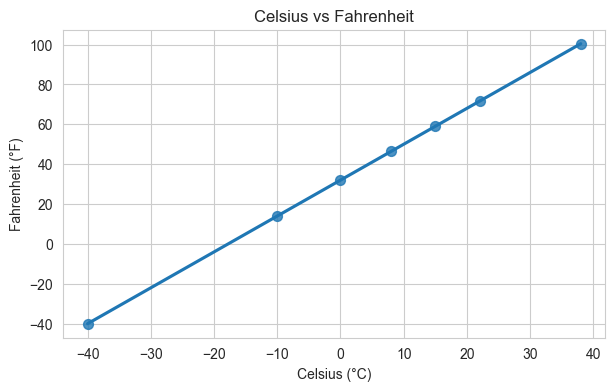

In [9]:
# Celsius -> Fahrenheit example
c = np.array([-40, -10, 0, 8, 15, 22, 38])
f = c * 9/5 + 32
df = pd.DataFrame({'Celsius': c, 'Fahrenheit': f})
df

plt.figure(figsize=(7,4))
sns.regplot(x='Celsius', y='Fahrenheit', data=df, ci=None, scatter_kws={'s':50})
plt.title('Celsius vs Fahrenheit')
plt.xlabel('Celsius (°C)')
plt.ylabel('Fahrenheit (°F)')
plt.show()

## Part 2 - Prediction (SciPy linregress)

Sections: Data Acquisition, Inspection, Cleaning, Descriptive Statistics, Build the Model, Predict, Visualizations

In [10]:
# Data acquisition - try local file first, then attempt to download a known raw path.
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
data_path = os.path.join(DATA_DIR, 'nyc_jan_highs.csv')
if not os.path.exists(data_path):
    print(f'{data_path} not found. Attempting to download from the Deitel repo (best-effort).')
    url = 'https://raw.githubusercontent.com/pdeitel/IntroToPythonLinks/master/data/nyc_jan_highs.csv'
    try:
        import urllib.request
        urllib.request.urlretrieve(url, data_path)
        print('Downloaded:', data_path)
    except Exception as e:
        print('Download failed:', e)
        print('If the download failed, please visit https://github.com/pdeitel/IntroToPythonLinks and place the CSV at', data_path)

# Load dataset if available, otherwise create a small demo dataframe so the notebook runs
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    print('Creating a small sample DataFrame for demo purposes (no dataset present).')
    years = np.arange(1895, 1905)
    temps = 34.2 + 0.01 * (years - 1895) + np.random.normal(scale=1.0, size=years.shape)
    df = pd.DataFrame({'Year': years, 'AvgHighJan': temps})

# Show initial rows
df.head()

data\nyc_jan_highs.csv not found. Attempting to download from the Deitel repo (best-effort).
Download failed: HTTP Error 404: Not Found
If the download failed, please visit https://github.com/pdeitel/IntroToPythonLinks and place the CSV at data\nyc_jan_highs.csv
Creating a small sample DataFrame for demo purposes (no dataset present).


,Year,AvgHighJan
0,1895,34.76
1,1896,35.35
2,1897,34.73
3,1898,33.39
4,1899,34.30


In [11]:
# Data cleaning and inspection
# Normalize column names and detect likely year/temp columns
df.columns = [c.strip() for c in df.columns]
possible_year_cols = [c for c in df.columns if 'year' in c.lower()]
possible_temp_cols = [c for c in df.columns if any(k in c.lower() for k in ['avg', 'temp', 'high'])]
print('Detected year columns:', possible_year_cols)
print('Detected temp columns:', possible_temp_cols)

if possible_year_cols:
    year_col = possible_year_cols[0]
else:
    year_col = df.columns[0]

if possible_temp_cols:
    temp_col = possible_temp_cols[0]
else:
    temp_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

df = df[[year_col, temp_col]].rename(columns={year_col: 'Year', temp_col: 'Temp'})
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df = df.dropna().reset_index(drop=True)

# Descriptive statistics
pd.set_option('display.precision', 2)
df.describe()

Detected year columns: ['Year']
Detected temp columns: ['AvgHighJan']


,Year,Temp
count,10.00,10.00
mean,1899.50,34.37
std,3.03,0.98
min,1895.00,33.29
25%,1897.25,33.59
50%,1899.50,34.16
75%,1901.75,34.75
max,1904.00,36.42


slope=-0.0256, intercept=82.93, r=-0.0788
Predicted avg high in Jan 2024 (linregress): 31.18


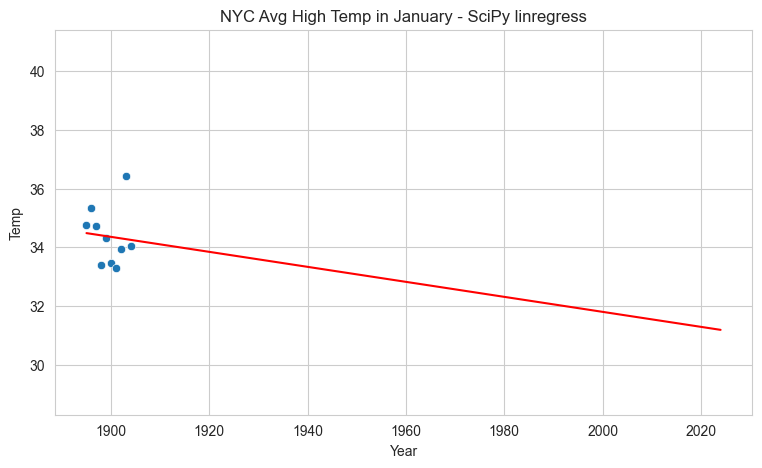

In [12]:
# Build the model using SciPy linregress and make a prediction for 2024
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Year'], df['Temp'])
print(f'slope={slope:.4f}, intercept={intercept:.2f}, r={r_value:.4f}')

def predict(year):
    return slope * year + intercept

pred_2024 = predict(2024)
print('Predicted avg high in Jan 2024 (linregress):', round(pred_2024, 2))

# Visualization with best-fit line
plt.figure(figsize=(9,5))
sns.scatterplot(x='Year', y='Temp', data=df)
xvals = np.array([df['Year'].min(), 2024])
yvals = slope * xvals + intercept
plt.plot(xvals, yvals, color='red')
plt.ylim(df['Temp'].min() - 5, df['Temp'].max() + 5)
plt.title('NYC Avg High Temp in January - SciPy linregress')
plt.show()

## Part 3 - Prediction (scikit-learn)

Split the data into training/testing sets, fit a LinearRegression estimator, test, predict, and visualize.

Shapes -> (8, 1) (2, 1) (8,) (2,)
coef_ = -0.10070335431012135 intercept_ = 225.27434019766815
Predicted avg high in Jan 2024 (sklearn): 21.45


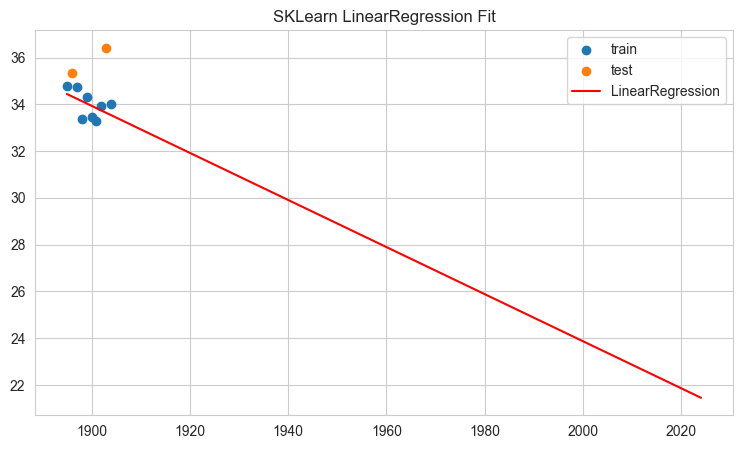

In [13]:
# Prepare data for scikit-learn
X = df['Year'].values.reshape(-1, 1)
y = df['Temp'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shapes ->', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Train LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
print('coef_ =', model.coef_[0], 'intercept_ =', model.intercept_)

# Predict 2024
pred_2024_sk = model.predict(np.array([[2024]]))[0]
print('Predicted avg high in Jan 2024 (sklearn):', round(pred_2024_sk, 2))

# Plot train/test and fitted line
plt.figure(figsize=(9,5))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
x_line = np.linspace(df['Year'].min(), 2024, 200).reshape(-1,1)
y_line = model.predict(x_line)
plt.plot(x_line, y_line, color='red', label='LinearRegression')
plt.legend()
plt.title('SKLearn LinearRegression Fit')
plt.show()

## Part 4 - Insights

Summary of results:
- The SciPy `linregress` and scikit-learn `LinearRegression` approaches produce very similar slope and intercept values (they both fit a straight line to the same data).
- The two predicted values for 2024 should be close; differences (if any) come from rounding and how the libraries handle internal computations.
- Model fit: a single linear model over the entire historical record may not capture multi-decade trends or non-linear changes. Check `r_value` from `linregress` and inspect residuals to assess fit.
- Limitations: this is a univariate, time-only model. It ignores other climatological predictors, potential autocorrelation, and heteroscedasticity.
- Next steps: try polynomial features or piecewise regressions, include additional predictors (e.g., global indices), or restrict the time window to recent decades to see if the trend differs. Also evaluate prediction uncertainty (prediction intervals) rather than a point estimate.

Interpretation guidance:
- Treat the 2024 prediction as an illustrative estimate, not a definitive forecast.
- Report both predictions (SciPy and scikit-learn) and the model statistics (slope, intercept, r, std_err) when summarizing findings.

---
How to run this notebook locally:
1. Ensure the `requirements.txt` dependencies are installed (see file at repository root).
2. From the project root, start JupyterLab or Jupyter Notebook and open `sgolla_ml.ipynb`.

Example (PowerShell):

In [14]:
# PowerShell example (run in a PowerShell terminal, not in a notebook cell):
# Install requirements (one-time):
# pip install -r requirements.txt
# Start Jupyter Lab: (from project root)
# jupyter lab

In [15]:
# Quick check: print versions of main libraries
import sys
print('python', sys.version.split()[0])
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('seaborn', sns.__version__)
import sklearn
print('scikit-learn', sklearn.__version__)
import scipy
print('scipy', scipy.__version__)


python 3.13.5
pandas 2.3.3
numpy 2.3.3
seaborn 0.13.2
scikit-learn 1.7.2
scipy 1.16.2
